In [ ]:
# install libs
!pip install cleanco
!pip install transliterate
!pip install thefuzz
!pip install abydos
!pip install python-Levenshtein
!pip install jellyfish
!pip install distance

In [ ]:
!pip install jaro-winkler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# google drive connection
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import dependencies
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.inspection import permutation_importance # feature importance definition
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc # for evaluation of algoritms

import re
import unicodedata
from cleanco import basename
from transliterate.decorators import transliterate_function
import difflib
import abydos.distance as abd
from thefuzz import fuzz
import Levenshtein, distance, jellyfish

import jaro # jaro-winkler

import warnings

warnings.filterwarnings("ignore")

In [ ]:
# loading features dataframe from Yandex disk
!wget -O features.csv https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/HDHHJc9-xfqNTw

--2022-10-26 16:55:47--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/HDHHJc9-xfqNTw
Resolving getfile.dokpub.com (getfile.dokpub.com)... 142.132.255.217
Connecting to getfile.dokpub.com (getfile.dokpub.com)|142.132.255.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/9aec4341270bb349eab0fcad402438c7ef29c83e9a9509c334cd6c5379ab5743/63599915/fKqInKw3d7bLFOeFnMGnhPE5A3In4LlsB_F_DLyGebCD-1XRp8lwstqQh3wprg8GP5E7iqf6dPsILybTDyQCXQaUnv-UylK5jpA7hMcdl5ar8npumZHI4midPdWhecNq?uid=0&filename=features.csv&disposition=attachment&hash=5BLZAVUe0v2Z3b5Z4O%2BnZ1QtdLA/pu1NxSs%2B1MweS/ZoDK5GKIk%2BFjjETkt2bgUJtFP6gwbjvtaafTptcua4SA%3D%3D%3A&limit=0&content_type=text%2Fplain&owner_uid=1130000062023445&fsize=97616808&hid=c18f4557ceefe9427b6252383525cfdb&media_type=spreadsheet&tknv=v2 [following]
--2022-10-26 16:55:48--  https://downloader.disk.yandex.ru/disk/9aec4341270bb349eab0fcad402438c7ef29c83e9a9509c334cd6c5379a

In [ ]:
df = pd.read_csv('features.csv', index_col='pair_id')
df.head()

,name_1,name_2,l,dl,ssk,ts,tsr,pr,wr,smr,js,jws,mra,mean,is_duplicate
pair_id,,,,,,,,,,,,,,,
1,iko industries,enormous industrial trade,0.564103,0.381090,0.589480,0.56,0.56,0.71,0.64,0.564103,0.590390,0.590390,1,0.574955,0
2,apcotex industries,technocraft industries india,0.608696,0.424665,0.671847,0.52,0.71,0.72,0.86,0.565217,0.695106,0.695106,0,0.647064,0
3,rishichem distributors,dsa,0.160000,0.119396,0.052106,0.16,0.16,0.67,0.60,0.080000,0.419192,0.419192,0,0.283989,0
4,powermax rubber factory,co one,0.206897,0.157061,0.108644,0.34,0.34,0.33,0.43,0.137931,0.432367,0.432367,0,0.291527,0
5,tress,longyou industries park zhejiang,0.216216,0.143389,0.156880,0.22,0.22,0.80,0.72,0.216216,0.585417,0.585417,0,0.386353,0


#### Highlighting the main features using GradientBoosting and LogisticRegression 

We use these algorithms because they don't sensitive to imbalanced classes problem in order to use for train all avaliable data. GradientBoosting and LogisticRegression were trained usinf features data without columns name_1 and name_2

##### train, test datasets preparation

In [ ]:
X = df.drop(['name_1', 'name_2', 'is_duplicate'], axis=1)
X.head(2)

,l,dl,ssk,ts,tsr,pr,wr,smr,js,jws,mra,mean
pair_id,,,,,,,,,,,,
1,0.564103,0.381090,0.589480,0.56,0.56,0.71,0.64,0.564103,0.590390,0.590390,1,0.574955
2,0.608696,0.424665,0.671847,0.52,0.71,0.72,0.86,0.565217,0.695106,0.695106,0,0.647064


In [ ]:
# target
y = df.is_duplicate
y.shape

(497819,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12)

##### GradientBoostingClassifier

In [ ]:
# 1 Experiment
# learning rate choosing
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1] 
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate=1., max_depth=2, random_state=42).fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.5f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (test): {0:.5f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.99269
Accuracy score (test): 0.99259

Learning rate:  0.1
Accuracy score (training): 0.99269
Accuracy score (test): 0.99259

Learning rate:  0.25
Accuracy score (training): 0.99269
Accuracy score (test): 0.99259

Learning rate:  0.5
Accuracy score (training): 0.99269
Accuracy score (test): 0.99259

Learning rate:  0.75
Accuracy score (training): 0.99269
Accuracy score (test): 0.99259

Learning rate:  1
Accuracy score (training): 0.99269
Accuracy score (test): 0.99259



In [ ]:
# GB traininf with particular learning rate. For this case we can choose any of the list
gb = GradientBoostingClassifier(n_estimators=50, learning_rate=1., max_depth=4, random_state=42).fit(X_train, y_train)

In [ ]:
# evaluation
predictions = gb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[161478   1586]
 [   757    460]]

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    163064
           1       0.22      0.38      0.28      1217

    accuracy                           0.99    164281
   macro avg       0.61      0.68      0.64    164281
weighted avg       0.99      0.99      0.99    164281



In [ ]:
# ROC curve and Area-Under-Curve (AUC)

y_scores_gb = gb.decision_function(X_test)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

Area under ROC curve = 0.51


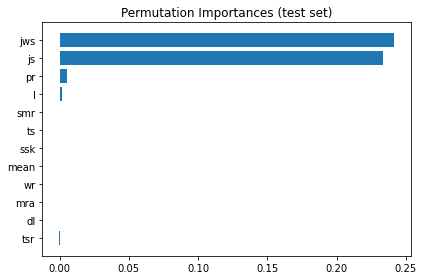

In [ ]:
# feautures choosing
result = permutation_importance(gb, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(X_test.columns[sorted_idx], result.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

######Logreg for features choosing

In [ ]:
# 2 experiment
logreg = LogisticRegression().fit(X_train, y_train)

# evaluation
predictions = logreg.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("Classification Report")
print(classification_report(y_test, predictions))

# ROC curve and Area-Under-Curve (AUC)

y_scores_logreg  = gb.decision_function(X_test)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_scores_logreg)
roc_auc_logreg  = auc(fpr_logreg , tpr_logreg)

print("Area under ROC curve = {:0.2f}".format(roc_auc_logreg))


Confusion Matrix:
[[162928    136]
 [   943    274]]

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    163064
           1       0.67      0.23      0.34      1217

    accuracy                           0.99    164281
   macro avg       0.83      0.61      0.67    164281
weighted avg       0.99      0.99      0.99    164281

Area under ROC curve = 0.51


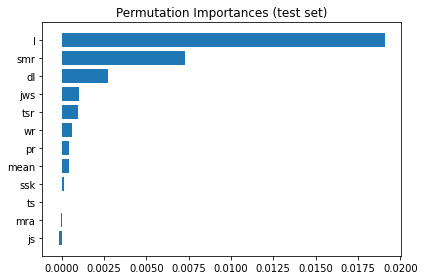

In [ ]:
result = permutation_importance(logreg, X_test, y_test, n_repeats=25,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(X_test.columns[sorted_idx], result.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

**Resume: we chose Jaro Similarity, Jaro-Winkler Similarity and Levenshtein features for inference**

#### Inference

In [ ]:
!wget -O train.csv https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/03C9AjRJqukWcg # load uncleaned original data

--2022-10-26 19:11:58--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/03C9AjRJqukWcg
Resolving getfile.dokpub.com (getfile.dokpub.com)... 142.132.255.217
Connecting to getfile.dokpub.com (getfile.dokpub.com)|142.132.255.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/87460a5b970639ba9e84d4f25b3d4754cb84a0860cb5a717bef0f42958ad73f9/6359b451/msMO0KQIAH3VfHbAiTRYc7IU3Nhh3xJ0wfmoVk6qNzxYgqaBMRY0efTvRnMIfEhMPEeBAfXl4uChRAP2dvlWOg%3D%3D?uid=0&filename=train_brands.csv&disposition=attachment&hash=Q%2BL0DOkc2P3%2BfmzFCyxRcXa2Pi%2B4abC8b81eIqanwFGKgEtQzyjIoJ0TbqC7RIGwq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=text%2Fplain&owner_uid=6709741&fsize=29759004&hid=d3075775f2ccb8067d5c2aa80ed316de&media_type=spreadsheet&tknv=v2 [following]
--2022-10-26 19:11:58--  https://downloader.disk.yandex.ru/disk/87460a5b970639ba9e84d4f25b3d4754cb84a0860cb5a717bef0f42958ad73f9/6359b451/msMO0KQIAH3VfHbAiTRYc7IU3N

In [ ]:
df_orig = pd.read_csv('train.csv', index_col='pair_id')
df_orig.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


In [ ]:
# choose random brand from original dataset
rand_i1 = random.randint(0, df.shape[0])
rand_i2 = random.randint(0, df.shape[0])
# took random names from dataset
test_brand1 = df.name_1.iloc[rand_i1]
test_brand2 = df.name_1.iloc[rand_i2]

In [ ]:
a = ord('а') # Cyrillic characters "А"
rus_alphabet = ''.join([chr(i) for i in range(a,a+6)] + [chr(a+33)] + [chr(i) for i in range(a+6,a+32)])

In [ ]:
def preprocessing(x: str) -> str:
    """Returns preprocessed string
    """
    
    def rus_preprocess(x: str) -> str:
        forms_of_ownership = [
            'ооо',
            'оао',
            'общество с ограниченной ответственностью',
            'открытое акционерное общество',
            'филиал компании'
        ]
        
        for form in forms_of_ownership:
            pattern = re.compile(form)
            x = pattern.sub('', x)
            
        return x
    
    @transliterate_function(language_code='ru', reversed=True)
    def translit(x: str) -> str:
        return x
    
    
    x = x.strip().casefold() # analoque of lower(), if simbols in latin1
    x = basename(x) if not bool(set(rus_alphabet).intersection(set(x.lower()))) else rus_preprocess(x)
    x = unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode() if not bool(set(rus_alphabet).intersection(set(x.lower()))) else translit(x)
    x = basename(x)
    x = re.sub(r'[^\w\s]',' ', x)
    
    return ' '.join([s for s in x.split() if len(s) > 1])

In [ ]:
seq1 = preprocessing(test_brand1)
seq2 = preprocessing(test_brand2)
print(f'name_1: {seq1} | name_2: {seq2}')

name_1: wacker chemical | name_2: bva


In [ ]:
# jaro-winkler
# if you will have error with jaro just reload import sell an all inference sell
jaro = jaro.jaro_winkler_metric(seq1, seq2)
lev = Levenshtein.ratio(seq1, seq2)
print(f'jaro_winkler = {round(jaro, 2)}')
print(f'Levenstain ratio = {round(lev, 2)}')
if jaro >= 0.69 and lev >= 0.53:
    print(f'names match')
else:
    print(f'Names do not match')

jaro_winkler = 0.47
Levenstain ratio = 0.11
Names do not match
